<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Basic/Neuron_apples_and_pears.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron

Here we'll learn how to write a simple Rosenblatt's perceptron - the first neural network ever created.

Let's import some necessary libs first

In [64]:
!wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Basic/data/apples_pears.csv

--2023-04-23 10:06:11--  https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Basic/data/apples_pears.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42590 (42K) [text/plain]
Saving to: ‘apples_pears.csv.1’

apples_pears.csv.1  100%[===================>]  41.59K  --.-KB/s    in 0.001s  

2023-04-23 10:06:11 (31.8 MB/s) - ‘apples_pears.csv.1’ saved [42590/42590]



In [65]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score,f1_score, recall_score,precision_score
from sklearn.model_selection import train_test_split


In [66]:
df = pd.read_csv("apples_pears.csv")

Let's define a **Loss function**. Let it be **MSE**. We divide by 2 since $Δ{x^2} = 2x$ and it just makes the computations faster by cancelling 2s when updating the weights. 

$$\frac{1}{2n}\sum_{i=1}^{n} (f(w \cdot X_i + b) - y_i)^2$$  

In [67]:
def Loss(y_pred, y):
  '''mse'''
  return 1/2 * np.mean(y_pred - y, axis=0)**2

In [68]:
a = np.array([[10,20,30],[21,22,23],[23,24,25]])
b = a*2.5
Loss(b, a)

array([364.5, 544.5, 760.5])

## Some visualization

We need functions to take a loot at loss func over iterations, plot the result of classification and plot metrics

In [69]:
def plot_ap(df:pd.DataFrame, target:pd.Series)->None:
  plt.scatter(df['yellowness'], df['symmetry'], c=target, cmap='spring')
  plt.title('Apples and pears')
  plt.xlabel('Symmetry')
  plt.ylabel('Yellowness')
  plt.show()

In [70]:
def plot_loss(losses:list)->None:
  """plot loss value by iteration"""
  plt.plot(losses)
  plt.title('Loss function')
  plt.xlabel('Iteration')
  plt.ylabel('Loss value')
  plt.show()

In [71]:
def print_score(y:pd.Series, y_pred:np.ndarray, name:str = 'Train')-> None:
  '''prints statistics for classification model'''
  print('print stats')
  print(name+' accuracy: ', accuracy_score(y, y_pred > 0.2))
  print(name+' F measure: ', f1_score(y, y_pred > 0.2))
  print(name+' ROC-AUC: ', roc_auc_score(y, y_pred))
  print()

## Perceptron class

We need functions that predict by applying WnB to the data (forward), that updats weigths while training (backward), activation function, training function and the one that predicts new data and prints some statistics.

In [72]:
class MyPerceptron:
  def __init__(self, w=None, b=0):
    self.w = w
    self.b = b

  def init_wnb(self, x:int)->None:
    '''zeroes weights and biases'''
    self.w = np.zeros((x, 1))
    self.b = 0
  
  @staticmethod
  def loss(y_pred, y):
    '''mse'''
    return 1/2 * np.mean(y_pred - y, axis=0)**2

  def activate(self, n:pd.DataFrame)->np.array:
    '''threshold activation function returns 1 if n > 0 else 0'''
    return np.array(n > 0, dtype = np.int32)

  def forward(self, X:pd.DataFrame):
    '''predicting function that multiplies w*X +b and activates the neuron'''
    return self.activate(X @ self.w + self.b)

  def backward(self, X:pd.DataFrame, y:np.ndarray, y_pred:np.ndarray, lr:int = 5e-3):
    '''update the weights using gradient descent'''
    self.w = self.w - (X.T @ (y_pred - y) /len(y)) * lr
    self.b = self.b - np.mean(y_pred - y, axis=0) * lr

  def fit(self, X:pd.DataFrame, y:pd.Series, n_iters:int=300)->list:
    '''train the model'''
    losses = []
    self.init_wnb(X.shape[1])
    y = y.values.reshape((-1,1))
    #backpropogation
    for n in range(n_iters):
      y_pred = self.forward(X)
      losses.append(self.loss(y_pred, y))
      self.backward(X, y, y_pred)
    return losses

  def run(self, X:pd.DataFrame, y:pd.Series, name = 'Train') ->None:
    '''predisct and show statistics'''
    y_pred = self.forward(X)
    print_score(y, y_pred, name)
    plot_ap(X, y_pred)


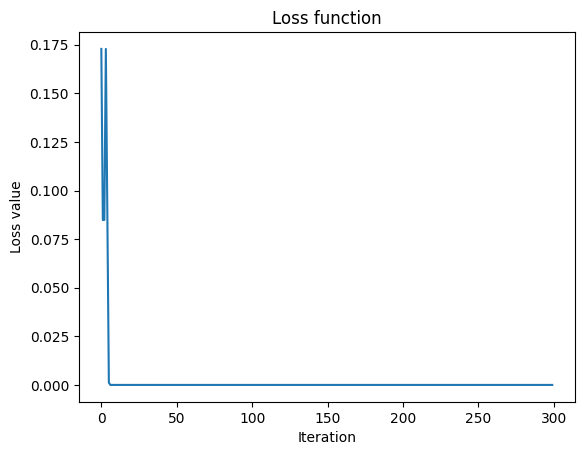

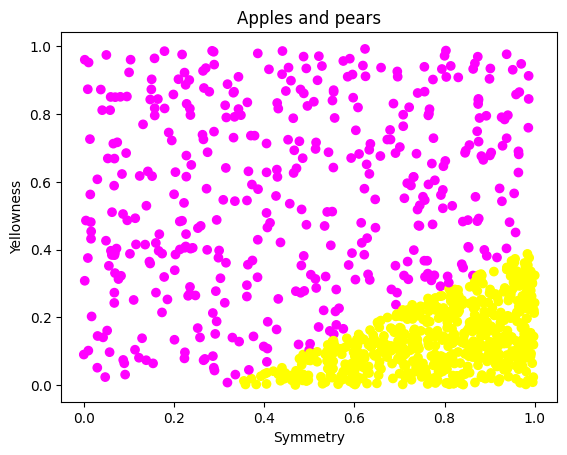

In [73]:
X = df[['yellowness', 'symmetry']]
y = df['target']

perceptron = MyPerceptron()
losses = perceptron.fit(X, y)
y_pred = perceptron.forward(df[['yellowness', 'symmetry']])
plot_loss(losses)
plot_ap(df, y_pred)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df[['yellowness', 'symmetry']], df['target'], test_size = 0.3, stratify = df['target'], random_state=42)

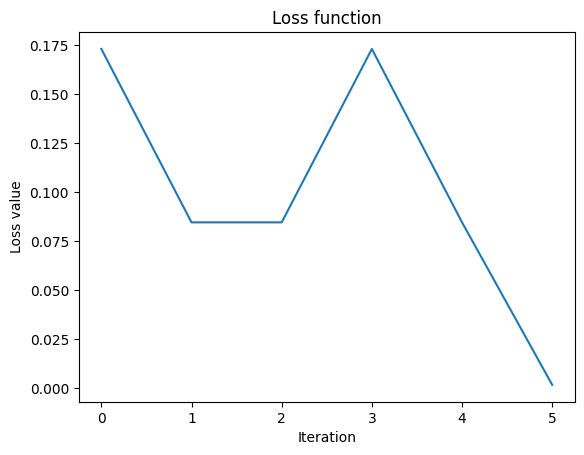

In [75]:
perc_new = MyPerceptron()
losses_new = perc_new.fit(X_train, y_train, n_iters = 6)
plot_loss(losses_new)

print stats
Train accuracy:  1.0
Train F measure:  1.0
Train ROC-AUC:  1.0



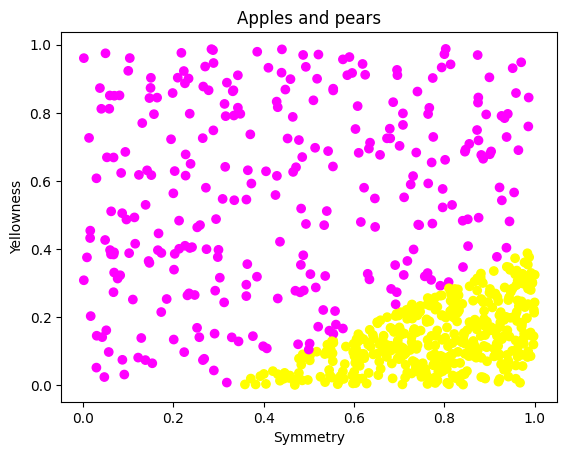

print stats
Test accuracy:  0.9966666666666667
Test F measure:  0.9971509971509972
Test ROC-AUC:  0.9971590909090908



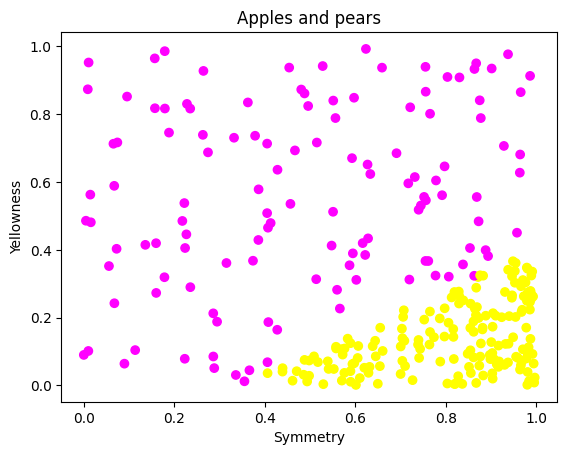

In [76]:
perc_new.run(X_train, y_train)
perc_new.run(X_test, y_test, 'Test')

# Neuron

Basically neuron is the same as rosenblatt's perceptron but the activation function is not a threshold one but could be chosen.

## Sigmoid activation function

Sigmoid activation function looks like this:

 $$\sigma(x)=\frac{1}{1+e^{-x}}$$


 So the loss function will be:

$$ \frac{1}{n}\sum_{i=1}^{n} (\frac{1}{1+e^{-w \cdot X_i}} - y_i)^2$$


The derivative of sigmoid is:

 $$\sigma(w \cdot x)(1-\sigma(w \cdot x))$$


For weight $w_j$ the loss function will be:

$$ \frac{\partial Loss}{\partial w_j} =  \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij}$$


And for the whole gradient it will be:

$$\frac{\partial Loss}{\partial w} = \frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

In [77]:
def sigmoid(x):
  '''activation function'''
  return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
  """derivative of sigmoid function"""
  return sigmoid(x) * (1 - sigmoid(x))

In [78]:
class Neuron(MyPerceptron):
  
  def activate(self, x):
    return sigmoid(x)
  
  def backward(self, X, y, y_pred, lr = 0.1):
    sigma = self.activate(X @ self.w + self.b)
    err_sd = (sigma-y) * sigma * (1 - sigma)

    self.w = self.w - lr * (X.T @ err_sd) / len(y)
    self.b = self.b - lr * np.mean(err_sd, axis=0)


In [118]:
def mark_pred(y_pred:np.array)->np.array:
  return np.array([int(x+0.5) for x in y_pred]).reshape(-1,1)

def get_stats(model, X:np.array, y:np.array, name:str = 'Train')->None:
  y_pred = model.forward(X)
  y_pred = mark_pred(y_pred)
  print(name+' loss:',neuron.loss(y_pred, y))
  neuron.run(X, y, name)


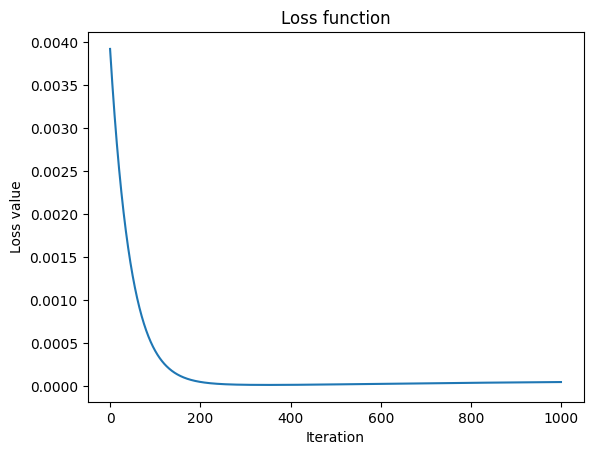

Train loss: [0.00589388]
print stats
Train accuracy:  0.6114285714285714
Train F measure:  0.7518248175182481
Train ROC-AUC:  0.9986599919093851

(700, 2)


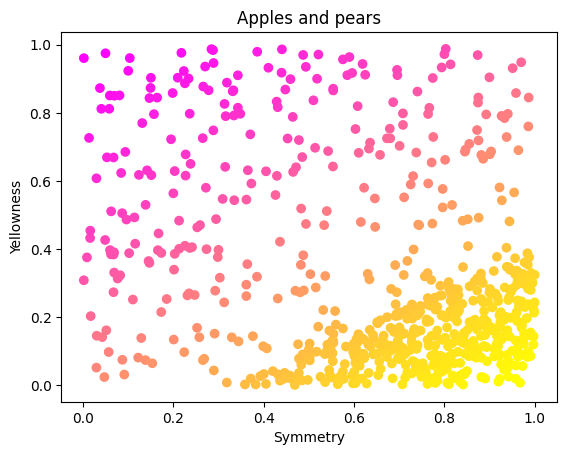

Test loss: [0.0098]
print stats
Test accuracy:  0.6033333333333334
Test F measure:  0.7473460721868366
Test ROC-AUC:  0.9983046187683285

(300, 2)


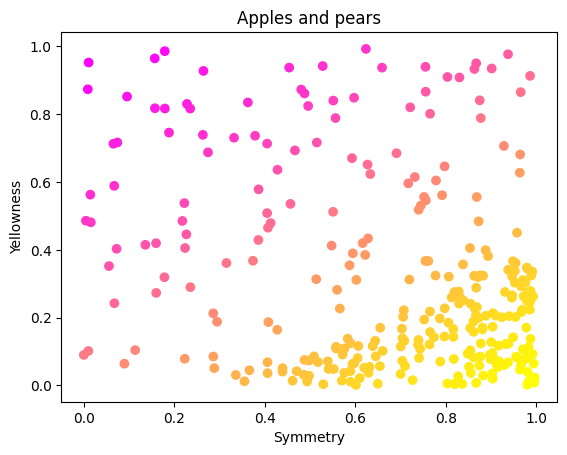

CPU times: user 1.15 s, sys: 74.2 ms, total: 1.22 s
Wall time: 2.56 s


In [123]:
%%time
neuron = Neuron()
new_loss= neuron.fit(X_train, y_train, n_iters = 1000)
plot_loss(new_loss)

get_stats(neuron, X_train, y_train)
get_stats(neuron, X_test, y_test, 'Test')

### Summary

So here is the gradient with sigmoid.
One thing to think about - using reshape(-1,1) on forward and backpropagation steps could increase the speed tenfold.

Anyways the thing is in classification problems **MSE** as Loss function is used close to never. Better option would be to use **LogLoss**

## LogLoss activation function